In [1]:
import numpy as np
import os
import subprocess
import theano
import gzip
import pickle
from IPython.display import clear_output
import random



In [2]:
TRAIN_PATH = 'secondary_proteins_prediction/data/cullpdb+profile_6133_filtered.npy.gz'
TEST_PATH =  'secondary_proteins_prediction/data/cb513+profile_split1.npy.gz'

In [3]:
def load_gz(path):  # load a .npy.gz file
    if path.endswith(".gz"):
        f = open(path, 'rb')
        return np.load(f)
    else:
        return np.load(path)

In [5]:
def get_train(path=TRAIN_PATH):
    
    X_in = load_gz(path)
    print(X_in.shape)
    X = np.reshape(X_in, (5534, 700, 57))
    del X_in
    X = X[:, :, :].astype(theano.config.floatX)
  
    seq_names = np.arange(0, np.size(X, 0))

    #X_train = X[seq_names[0:5278]]
    X_train = X[seq_names[0:5534]] #this is used for utilising the entire dataset as train
    X_valid = X[seq_names[5278:5534]]
    
    return X_train, X_valid

In [6]:
X_train, X_valid= get_train(TRAIN_PATH)
print("Done loading train")
print(X_train.shape)

(5534, 39900)
Done loading train
(5534, 700, 57)


[2.27021e+05 1.21760e+04 2.57733e+05 4.62750e+04 2.12000e+02 4.08663e+05
 9.77160e+04 1.33522e+05]


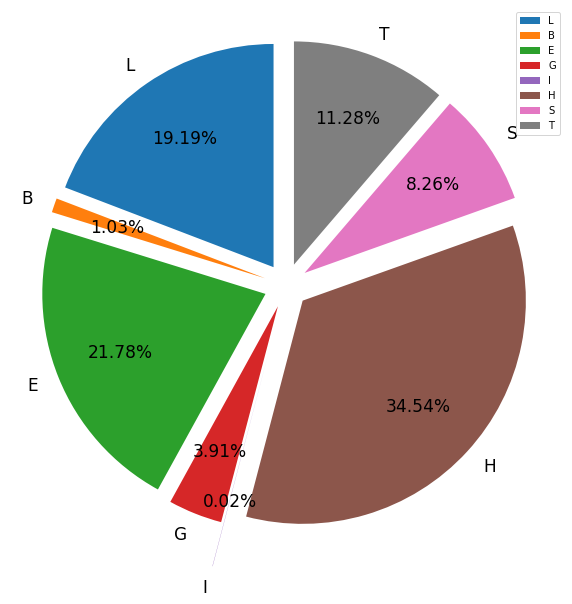

In [19]:
import matplotlib.pyplot as plt


sizes = np.zeros(8)
for i in range(X_train.shape[0]):
    for j in range(X_train.shape[1]):
        if X_train[i,j,22:30].sum() != 0:
            index = X_train[i,j,22:30].argmax()
            sizes[index] += 1
print(sizes)        
# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'L', 'B', 'E', 'G', 'I', 'H', 'S', 'T'
explode = (0.1, 0.1, 0.1, 0.1, 0.3,0.1, 0.1, 0.1)  # only "explode" the 2nd slice (i.e. 'Hogs')

fig1, ax1 = plt.subplots()
fig1.set_size_inches(10,15)
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.2f%%', startangle=90, pctdistance  = 0.7, textprops={'fontsize': 17})

plt.legend()
plt.savefig("train-pie", bbox_inches = 'tight',
    pad_inches = 0)
plt.show()

In [10]:
def get_test(path=TEST_PATH):
    
    X_test_in = load_gz(path)
    X_test = np.reshape(X_test_in, (514, 700, 57))
    del X_test_in
    X_test = X_test[:, :, :].astype(theano.config.floatX)

    return X_test

In [11]:
X_test = get_test(TEST_PATH)
print("Done loading test")
print(X_test.shape)

Done loading test
(514, 700, 57)


In [14]:
#To do: Make 1 hot encoded class - from Q8 to Q3
       #Reshape the dataset so it has 700*windowSize seq that map to a class
       #Look inside lasagne to see how we disregard the padding
##

def q8ClassToQ3(q8Labels):
    
    q3 = np.zeros(3)
    index = np.argmax(q8Labels)
    
    #Helix
    if index == 5 or index == 3 or index == 4 : # H ,G, I
        q3[0] = 1   
    #beta    
    if index == 1 or index == 2: # B, E
        q3[1] = 1    
    #coil    
    if index == 7 or index == 6 or index == 0 : # T, S, L
        q3[2] = 1
    return q3

def q8ClassToQ2(q8Labels):
    
    q2 = np.zeros(2)
    index = np.argmax(q8Labels)
    #Helix
    if index == 5: # or index == 3 or index == 4 : # H ,G, I
        q2[0] = 1
    else:
        q2[1] = 1  
    return q2

def q8toQ8(q8Labels):
    return q8Labels

def changeQ8Class(dataSet, reductionFunction, numberOfFeatures):

    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    labels_new = np.zeros((num_seqs, seqlen, numberOfFeatures))

    for i in range(np.size(dataSet, axis=0)):
        for j in range(np.size(dataSet, axis=1)):
            oneHot = reductionFunction(dataSet[i, j, 22:30])
            features = np.concatenate((dataSet[i, j, 0:21], oneHot), axis=None)
            features = np.concatenate((features, dataSet[i, j, 35:56]), axis=None)
            labels_new[i][j] = features
    return labels_new


In [15]:
def swapClassLabel(features, classLabel, classSize):

    res = np.concatenate((features[0:21], classLabel), axis=None)
    res = np.concatenate((res, features[ (21+classSize) :]), axis=None)
  
    return res

In [16]:
import math

#num_classes should be q8, q3 or maybe q2?
def proteinSequenceToWindowSequence(windowSize, predictionIndex , dataSet, classSize):
   
    num_seqs = np.size(dataSet, 0)
    seqlen = np.size(dataSet, 1)
    features = np.size(dataSet, 2)
    dataSet_new = np.zeros((num_seqs, seqlen - windowSize + 1, windowSize, features))
    
    for i in range(np.size(dataSet, axis=0)):
        if i % 100 == 0:
            print(i)
        for j in range(np.size(dataSet, axis=1) - windowSize):
            classLabel = dataSet[i][j + predictionIndex][21 : (21+classSize) ]
            for k in range(windowSize):
                if predictionIndex != 0:
                    dataSet_new[i][j][k] = swapClassLabel(dataSet[i][j+k], classLabel, classSize)
                else:
                    dataSet_new[i][j][k] = swapClassLabel(dataSet[i][j+k+1], classLabel, classSize)
            
    return dataSet_new    

In [17]:
def removeWindowsWithPadding(dataSet, windowSize, numberOfFeatures):
    
    dataSet = np.reshape(dataSet, (dataSet.shape[0]*dataSet.shape[1], windowSize, numberOfFeatures))
    dataSet = dataSet[np.count_nonzero( dataSet, axis=(1,2))>(int(windowSize/2)*23), :, :] 
    
    return dataSet

In [18]:
def get_reshaped_dataset(X_train, X_valid, reductionFunction, numberOfFeatures, classSize, predictionIndex, windowSize):
    #print(X_train.shape)
    #X_train = changeQ8Class(X_train, reductionFunction, numberOfFeatures)
    print(X_train.shape, "changed train data to class of size ", classSize)
    X_train_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_train, classSize)
    print(X_train_window.shape, "changed train data  to window sequence of size ", windowSize)
    X_train_window = removeWindowsWithPadding(X_train_window , windowSize, numberOfFeatures)
    print(X_train_window.shape, "filtered windows withouth padding of train data ")

    #print(X_valid.shape)
    X_valid_window = 0
    #X_valid = changeQ8Class(X_valid, reductionFunction, numberOfFeatures)
    #print(X_valid.shape, "changed validation data to class size ", classSize)
    #X_valid_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_valid, classSize)
    #print(X_valid_window.shape, "changed validation data to window sequence of size ", windowSize)
    #X_valid_window = removeWindowsWithPadding(X_valid_window , windowSize, numberOfFeatures)
    #print(X_valid_window.shape, "filtered windows withouth padding of validation data")
    
    return X_train_window, X_valid_window

In [19]:
def one_hot_to_tapped(oneHot, index, windowSize):

    oneHot = oneHot.copy()
    newOne = 0.5/(windowSize - 1) * index + 0.5
    newZero = (1 - newOne) / (np.size(oneHot) - 1)
        
    oneHot = oneHot.astype(theano.config.floatX)
    oneHot[ oneHot == 1] = newOne
    oneHot[ oneHot == 0] = newZero

    return oneHot

In [20]:
def get_tapped_one_dataset(dataSet, windowSize, classSize):
    
    newDataSet = dataSet.copy()
    for i in range(np.size(newDataSet, axis=1)): 
        for j in range(np.size(newDataSet, axis=1)):

            oneHot = one_hot_to_tapped( newDataSet[i, j, 0:21], j, windowSize)
            features = np.concatenate((oneHot, newDataSet[i, j, 21:]), axis=None)
            newDataSet[i][j] = features
    
    return newDataSet


In [21]:
def get_split(X_train, X_valid, classSize, pssm = False):

    if not pssm:
        return (X_train[:,:,0:21], X_train[:,:,21 : (21+classSize)], 
                X_valid[:,:,0:21], X_valid[:,:,21 : (21+classSize)])
    else:
        return (X_train[:,:,21+classSize:], X_train[:,:,21 : (21+classSize)],
                X_valid[:,:,21+classSize:], X_valid[:,:,21 : (21+classSize)])

In [22]:
windowSize = 19 #19
predictionIndex = 9
classSize = 8  # 2 or 3 
numberOfFeatures = 50 #50 #44 #45


In [4]:

for i in range(19):
    print("reading casp part dataset")
    f = gzip.GzipFile( 'casp12/training_100-' + str(i) + '.npy.gz',  "r")
    dataset_part =  np.load(f)
    print(dataset_part.shape)
    
    X_train_window = get_w19_dataset(dataset_part)
    #X_train_window, X_valid_window = get_reshaped_dataset(dataset_part, 0, q8toQ8, numberOfFeatures, classSize, predictionIndex, windowSize)
    print(X_train_window.shape)
    
    del dataset_part
    print("saving casp part window dataset")
    g = gzip.GzipFile( 'casp12/training_100-' + str(i) + 'window19Middle-repeating-left' +'.npy.gz', "w")
    np.save(g, X_train_window)
    g.close()
    del X_train_window

489  *** 
(1146129, 19, 50)
saving casp part window dataset


In [ ]:
X_train_window, X_valid_window = get_reshaped_dataset(X_train, X_valid, q8toQ8, numberOfFeatures, classSize, predictionIndex, windowSize)

In [ ]:
f = gzip.GzipFile('all_dataset_window9LeftSideQ2.npy.gz', "w")
np.save(f, X_train_window)
f.close()

In [ ]:
g = gzip.GzipFile('X_valid_window19Middle.npy.gz', "w")
np.save(g, X_valid_window)
g.close()

In [ ]:
X_test = changeQ8Class(X_test, q8ClassToQ2, numberOfFeatures)
X_test_window = proteinSequenceToWindowSequence(windowSize,predictionIndex, X_test, classSize)
X_test_window = removeWindowsWithPadding(X_test_window , windowSize, numberOfFeatures)
print(X_test_window.shape)


In [ ]:
f = gzip.GzipFile('cb513_window19Q2.npy.gz', "w")
np.save(f, X_test_window)
f.close()

In [3]:
def get_w19_dataset(X_train):
    
    #X_train = X_valid
    allValidWindows = []

    for i in range(X_train.shape[0]):
    
        print("protein nr " ,i)
        clear_output(wait=True)
    
        lastIndex = 700
        #finding noseq
        for k in range(700):
            if(X_train[i,k,29:].sum() == 0):
                lastIndex = k
                print(lastIndex, " *** ")
                break

        #creating padding version so we do not loose information
        padded = np.zeros((700+18, 50))
        padded[9:709] = X_train[i]
    
        for k in range(9):
            #padded[8-k] = X_train[i,lastIndex - 1 - k]
            padded[k] = X_train[i,0] #0#X_train[i,random.randint(0, lastIndex - 1)] #
    
        nexta = 0
        for k in range(lastIndex + 9 , lastIndex + 9 + 9):
            #padded[k] = X_train[i,0 + nexta]
            nexta += 1
            padded[k] = 0#X_train[i,lastIndex - 1]#X_train[i,random.randint(0, lastIndex - 1)]#
        
    
    
        for k in range(718 - 19 + 1):
            #no seq reached
            if X_train[i,k,29:].sum() == 0:
                break
            
            window =  padded[k:k+19]
            #setting the same label
            window[:,21:29] = X_train[i,k, 21:29]
            allValidWindows.append(window)         
     
    return np.array(allValidWindows)

In [12]:

X_train = X_test
allValidWindows = []

for i in range(X_train.shape[0]):
    
    print("protein nr " ,i)
    clear_output(wait=True)
    
    lastIndex = 700
    #finding noseq
    for k in range(700):
        if(X_train[i,k,22:30].sum() == 0):
            lastIndex = k
            break

    #creating padding version so we do not loose information
    padded = np.zeros((700+18, 57))
    padded[9:709] = X_train[i]
    
    for k in range(9):
        #padded[8-k] = X_train[i,lastIndex - 1 - k]
        padded[k] = X_train[i,0] #0#X_train[i,random.randint(0, lastIndex - 1)] #
    
    nexta = 0
    for k in range(lastIndex + 9 , lastIndex + 9 + 9):
        #padded[k] = X_train[i,0 + nexta]
        nexta += 1
        padded[k] = 0#X_train[i,lastIndex - 1]#X_train[i,random.randint(0, lastIndex - 1)]#
    
    
    
    for k in range(718 - 19 + 1):
        #no seq reached
        if X_train[i,k,0:21].sum() == 0:
            break
            
        window =  padded[k:k+19]
        #setting the same label
        window[:,22:30] = X_train[i,k, 22:30]
        allValidWindows.append(window)         

protein nr  513


In [13]:
nump = np.array(allValidWindows)
del allValidWindows
del X_train
del X_valid

In [14]:
nump.shape

(84765, 19, 57)

In [15]:
f = gzip.GzipFile('cb513-window19Middle-repeating-left-right0.npy.gz', "w")
np.save(f, nump)
f.close()